In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import json
import pickle
import math
import itertools
import time
import requests
from ortools.linear_solver import pywraplp
from sklearn.linear_model import LinearRegression
from scipy import optimize as opt
from scipy.optimize import minimize

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['PYSPARK_PYTHON'] = '/home/luban/anaconda3/envs/python36/bin/python'
import findspark
findspark.init()

from pyspark import *
from pyspark.sql import *

app_name = 'zhangjiabao_jupyter'
conf = (SparkConf().setAppName(app_name)
        .set('spark.master', 'yarn')
        .set('spark.submit.deployMode', 'client')
        .set('spark.driver.memory',                  '10g')
        .set('spark.executor.memory',                '6g')
        .set('spark.dynamicAllocation.minExecutors', '50')
        .set('spark.dynamicAllocation.maxExecutors', '100')
        .set('spark.yarn.queue',                     'celuemoxingbu_driver_service_score_orig')
        .set('spark.ui.port','8060')
        .set('spark.executor.memoryOverhead','4096')
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set('spark.driver.allowMultipleCoo nntexts', 'True')
        .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2')
        .set('spark.pyspark.driver.python',          '/home/luban/anaconda3/envs/python36/bin/python')
        .set('spark.pyspark.python', './python3.6.2/bin/python')
        .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
        )
spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()

from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
import pandas as pd
import numpy as npx
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
import matplotlib.pyplot as plt

In [3]:
crdf = spark.sql("""
select
        city_id
        ,dt
        ,cast(objective_call_cnt as Double) as obj_call
        ,cast(total_tsh as Double) tsh
        ,cast(finish_order_cnt as Double) finish
        ,cast(nvl(total_tsh/objective_call_cnt, 0) as Double) gongxuc --供需比
        ,cast(nvl(objective_call_cnt/total_tsh, 0) as Double) xugong --需供比
        ,cast(nvl(finish_order_cnt_exp_openapi/objective_call_cnt_exp_openapi,0) as Double) true_obj_cr --剔除openapi的cr
        ,cast(gmv as Double)
from
    mp_data.dm_trip_mp_sd_core_1d
where
    dt between '2023-01-01' and '2023-05-15'
    and product_id = '110100_110400_110800_110103' --新泛快
    and total_tsh>0
""").toPandas()

In [4]:
tdf = spark.sql("""
select
    city_id
    ,gmv_type --城市分框
    ,city_type --区域
from 
    smt_stg.smt_err_budget_alloc_city_t1
where 
    dt = '2023-05-16'
""").toPandas()

In [5]:
crdf = pd.merge(crdf, tdf, on=['city_id'])

In [6]:
data = crdf[crdf['gmv_type'].isin(['大城市', '中城市'])]
data

,city_id,dt,obj_call,tsh,finish,gongxuc,xugong,true_obj_cr,gmv,gmv_type,city_type
540,22,2023-02-10,152638.0,64161.400000,114066.0,0.420350,2.378969,0.761727,2383419.35,中城市,非战区非下沉
541,22,2023-02-09,178404.0,57561.950000,108766.0,0.322649,3.099339,0.632677,2190691.29,中城市,非战区非下沉
542,22,2023-03-14,106509.0,63510.750000,89786.0,0.596295,1.677023,0.857603,1875878.16,中城市,非战区非下沉
543,22,2023-01-04,80837.0,53624.033333,70021.0,0.663360,1.507477,0.870890,1439319.31,中城市,非战区非下沉
544,22,2023-03-22,104692.0,65537.633333,87296.0,0.626004,1.597433,0.847924,1777066.15,中城市,非战区非下沉
...,...,...,...,...,...,...,...,...,...,...,...
32855,102,2023-03-27,103049.0,37984.866667,73156.0,0.368610,2.712896,0.734611,1172914.10,中城市,非战区非下沉
32856,102,2023-04-21,76038.0,40783.266667,62331.0,0.536354,1.864441,0.836830,1119177.89,中城市,非战区非下沉
32857,102,2023-03-20,67240.0,36544.616667,53547.0,0.543495,1.839943,0.809086,971449.79,中城市,非战区非下沉
32858,102,2023-03-16,61261.0,37067.833333,51371.0,0.605080,1.652673,0.849353,919593.58,中城市,非战区非下沉


In [13]:
def f(x, a, b, w):
    k = 1/(a*(2 - 1/(1 + w*b)**(1 - a)))
    y = np.empty(len(x))
    y[x >= b] = k*a/(w*x[x >= b] - w*b + 1)**(1 - a)
    y[x < b] = -(k*a)/(1 + w*b - w*x[x < b])**(1 - a) + 2*k*a
    return y

In [35]:
def fit(X, Y, b_low, b_up, iter_num=1e6):
    num = int(iter_num**(1/3)) + 2
    mse = np.inf
    for a in np.linspace(0, 1, num)[1:-2]:
        for b in np.linspace(b_low, b_up, num)[1:-2]:
            for w in np.linspace(0, 1/((1 - a)*b), num)[1:-2]:
                Y_pred = f(X, a, w, b)
                if ((Y_pred - Y)**2).sum() < mse:
                    a_, b_, w_ = a, b, w
                    mse = ((Y_pred - Y)**2).sum()
    return a_, b_, w_

In [ ]:
-52.74159668960331*y+70.30593996866077 -34.2310573449055 17.015893208933893

大城市 R2=0.7957905529681758


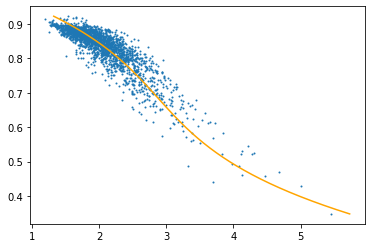

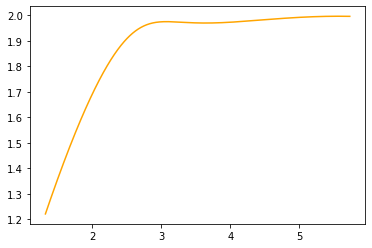

In [21]:
gmv_type = '大城市'
X = crdf[crdf['gmv_type'] == gmv_type]['xugong'].values
Y = crdf[crdf['gmv_type'] == gmv_type]['true_obj_cr'].values
regressor = LinearRegression(fit_intercept=True)
regressor.fit(np.concatenate((Y.reshape(-1, 1), Y.reshape(-1, 1)**2, Y.reshape(-1, 1)**3), axis=1), X)
a, b, c = regressor.coef_
d = regressor.intercept_
y = np.linspace(Y.min(), Y.max(), 1000)
x = -34.2310573449055*y**3 + 70.30593996866077*y**2 - 52.74159668960331*y + 17.015893208933893
print(f'{gmv_type} R2={regressor.score(np.concatenate((Y.reshape(-1, 1), Y.reshape(-1, 1)**2, Y.reshape(-1, 1)**3), axis=1), X)}')
plt.plot(x[(x > 0) & (x < 10)], y[(x > 0) & (x < 10)], color='orange')
plt.scatter(X, Y, s=1)
plt.show()
xy = x*y
plt.plot(x[(x > 0) & (x < 10)], xy[(x > 0) & (x < 10)], color='orange')
plt.show()

In [19]:
a, b, c, d

(-52.74159668960331, 70.30593996866077, -34.2310573449055, 17.015893208933893)

尾部城市 R2=0.032310818250648965


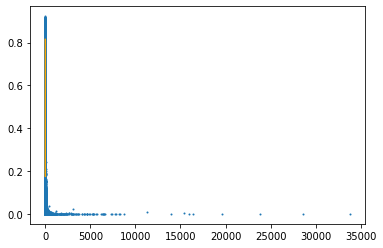

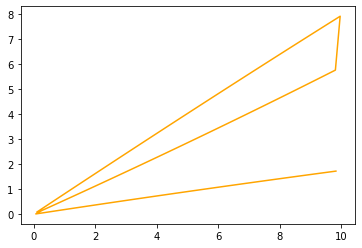

小城市 R2=0.6818744582608514


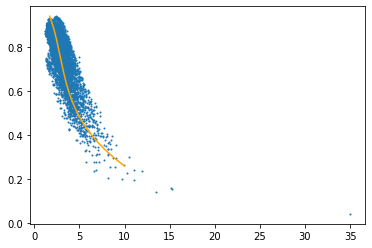

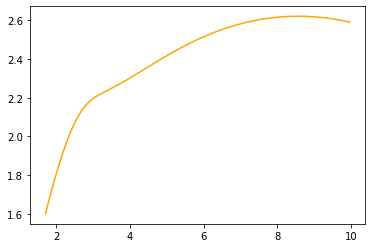

中城市 R2=0.5919631340698375


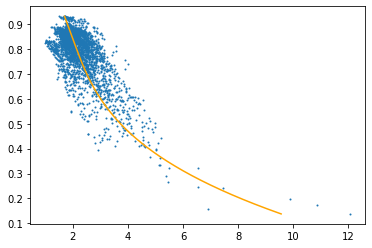

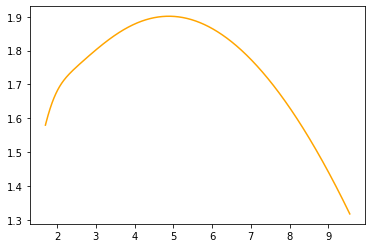

大城市 R2=0.7957905529681758


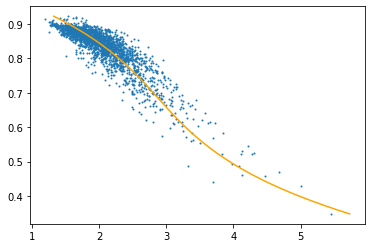

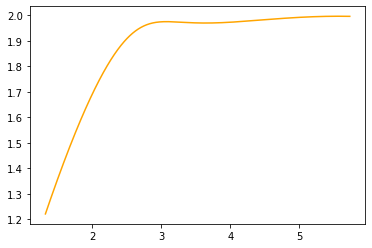

特大城市 R2=0.8670233983068908


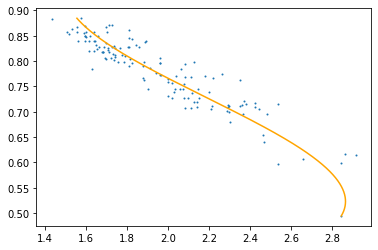

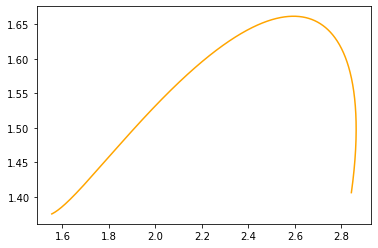

In [188]:
for gmv_type in list(crdf['gmv_type'].drop_duplicates()):
    X = crdf[crdf['gmv_type'] == gmv_type]['xugong'].values
    Y = crdf[crdf['gmv_type'] == gmv_type]['true_obj_cr'].values
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(np.concatenate((Y.reshape(-1, 1), Y.reshape(-1, 1)**2, Y.reshape(-1, 1)**3), axis=1), X)
    a, b, c = regressor.coef_
    d = regressor.intercept_
    y = np.linspace(Y.min(), Y.max(), 1000)
    x = d + a*y + b*y**2 + c*y**3
    print(f'{gmv_type} R2={regressor.score(np.concatenate((Y.reshape(-1, 1), Y.reshape(-1, 1)**2, Y.reshape(-1, 1)**3), axis=1), X)}')
    plt.plot(x[(x > 0) & (x < 10)], y[(x > 0) & (x < 10)], color='orange')
    plt.scatter(X, Y, s=1)
    plt.show()
    xy = x*y
    plt.plot(x[(x > 0) & (x < 10)], xy[(x > 0) & (x < 10)], color='orange')
    plt.show()

In [175]:
def objective(coef):
	return ((X - coef[0]*Y**3 - coef[1]*Y**2 - coef[2]*Y - coef[3])**2).sum()

def con_eq(coef):
	return coef[0] + coef[1] + coef[2] + coef[3]

def con_ineq1(coef):
	y = np.linspace(Y.min(), Y.max(), 1000)
	x = coef[0]*y**3 + coef[1]*y**2 + coef[2]*y + coef[3]
	ix = x.argsort().argsort()
	x = x[ix]
	y = y[ix]
	xy = x*y
	return (xy[:-1] - xy[1:]).min()

# def con_ineq2(coef):
# 	return (((6*coef[0]*Y + 2*coef[1])*(coef[0]*Y**3 + coef[1]*Y**2 + coef[2]*Y + coef[3]))/(3*coef[0]*Y**2 + 2*coef[1]*Y + coef[2])**3 - 2/(3*coef[0]*Y**2 + 2*coef[1]*Y + coef[2])).min()


3.3881317890172014e-21
-1.0407693897982609e-09
0.5919631340698377


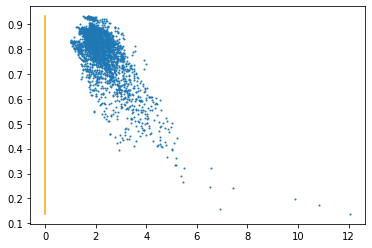

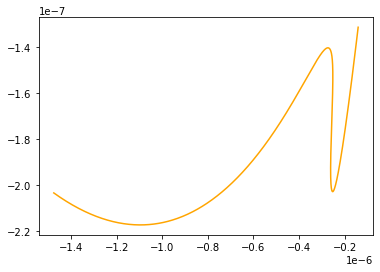

In [179]:
X = crdf[crdf['gmv_type'].isin(['中城市'])]['xugong'].values
Y = crdf[crdf['gmv_type'].isin(['中城市'])]['true_obj_cr'].values
regressor = LinearRegression(fit_intercept=True)
regressor.fit(np.concatenate((Y.reshape(-1, 1)**3, Y.reshape(-1, 1)**2, Y.reshape(-1, 1)), axis=1), X)
a, b, c = regressor.coef_
d = regressor.intercept_
bnds = ((None, None), (None, None), (None, None), (None, None))
con1 = {'type': 'eq', 'fun': con_eq}
con2 = {'type': 'ineq', 'fun': con_ineq1}
# con3 = {'type': 'ineq', 'fun': con_ineq2}
cons = ([con1, con2])
x0 = np.array([a, b, c, d])
solution = minimize(objective, x0, method='SLSQP',  bounds=bnds, constraints=cons)
coef = solution.x
print()
print(con_eq(coef))
print(con_ineq1(coef))
y = np.linspace(Y.min(), Y.max(), 1000)
x = coef[0]*y**3 + coef[1]*y**2 + coef[2]*y + coef[3]
print(regressor.score(np.concatenate((Y.reshape(-1, 1)**3, Y.reshape(-1, 1)**2, Y.reshape(-1, 1)), axis=1), X))
plt.plot(x, y, color='orange')
plt.scatter(X, Y, s=1)
plt.show()
xy = x*y
plt.plot(x, xy, color='orange')
plt.show()

In [37]:
X = crdf[crdf['gmv_type'].isin(['大城市', '中城市'])]['xugong'].values
Y = crdf[crdf['gmv_type'].isin(['大城市', '中城市'])]['true_obj_cr'].values
regressor = LinearRegression(fit_intercept=True)
regressor.fit(np.concatenate((Y.reshape(-1, 1)**3, Y.reshape(-1, 1)**2, Y.reshape(-1, 1)), axis=1), X)
a, b, c = regressor.coef_
d = regressor.intercept_

In [38]:
iter_num = 20
a_ = np.linspace(0, 2*a, iter_num + 1)[1:].reshape(-1, 1, 1, 1, 1)
b_ = np.linspace(0, 2*b, iter_num + 1)[1:].reshape(1, -1, 1, 1, 1)
c_ = np.linspace(0, 2*c, iter_num + 1)[1:].reshape(1, 1, -1, 1, 1)
d_ = np.linspace(0, 2*d, iter_num + 1)[1:].reshape(1, 1, 1, -1, 1)

In [39]:
x_pred = a_*Y**3 + b_*Y**2 + c_*Y + d_
xy_grad = Y + x_pred/(3*a_*Y**2 + 2*b_*Y + c_)

In [40]:
mse = ((x_pred - X)**2).sum(axis=4)
mse[xy_grad.min(axis=4) < 0] = np.inf

In [41]:
ix = np.unravel_index(mse.argmin(), mse.shape)
a = np.linspace(0, 2*a, iter_num + 1)[1:][ix[0]]
b = np.linspace(0, 2*b, iter_num + 1)[1:][ix[1]]
c = np.linspace(0, 2*c, iter_num + 1)[1:][ix[2]]
d = np.linspace(0, 2*d, iter_num + 1)[1:][ix[3]]

R2=0.6295706764688284


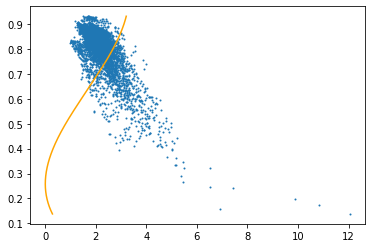

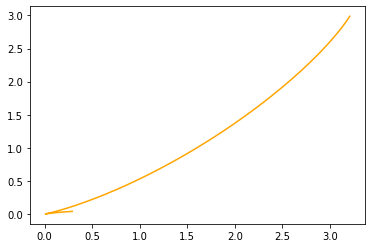

In [42]:
y = np.linspace(Y.min(), Y.max(), 1000)
x = a*y**3 + b*y**2 + c*y + d
print(f'R2={regressor.score(np.concatenate((Y.reshape(-1, 1)**3, Y.reshape(-1, 1)**2, Y.reshape(-1, 1)), axis=1), X)}')
plt.plot(x[(x > 0) & (x < 10)], y[(x > 0) & (x < 10)], color='orange')
plt.scatter(X, Y, s=1)
plt.show()
xy = x*y
plt.plot(x[(x > 0) & (x < 10)], xy[(x > 0) & (x < 10)], color='orange')
plt.show()